In [33]:
import os
import platform
import sys
import requests
import json
import operator
import time
import datetime
import nltk
import matplotlib
import matplotlib.pyplot as pyplot

if not os.path.exists('..\\output'):
    os.makedirs('..\\output')
    
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
time.sleep(1)
print('_______________________________________________')

2018-10-13 12:02:01
_______________________________________________


In [34]:
from nltk import ngrams, FreqDist
from nltk.corpus import stopwords

In [35]:
def writeText(text, path, mode = 'a'):
    with open (path, mode) as textout:
        textout.write((text))
        
def writeJson(json, path, mode = 'w'):
    with open(path, mode) as file:
        file.write(json.dumps(json))
        
def writeCsv(listOut, outputFile):
    import csv
    with open (outputFile, "w", newline='', encoding = 'ANSI') as outputfile:
        writer = csv.writer(outputfile, delimiter = ",")
        for element in listOut:
            writer.writerow(element)

def getTxt(path):
    return open(path, 'r').read()

In [36]:
def getToken():
    if platform.system() == 'Windows':
        return open('..\\token\\token.txt', 'r').read()
    else:
        return open('../token/token.txt', 'r').read()

In [37]:
def getJsonDocs(page = 1, itemsperpage = 200):
    jsondata ='dummy'
    list_return = []

    while jsondata:
        try:
            r = requests.get("https://app.23degrees.io/services/pub/api/v1/opendata/getWorldBankDataSetsPaginated/"+str(page)+"/"+str(itemsperpage)
                         ,timeout=None
                         ,headers={  'Content-Type': 'application/json'
                                    , 'Authorization' : 'Bearer '+ getToken()
                                   }
                        )    
            jsondata = r.json()
            for elem in jsondata:
                list_return.append(elem)
        except requests.exceptions.HTTPError as err:
            print(err)
        page += 1
    return list_return

In [38]:
list_js_docs = getJsonDocs(1,200)

In [39]:
list_js_docs[5]

{'_id': '5b9a455c65d715001bce269e',
 'description': 'Public expenditure on health from domestic sources as a share of total public expenditure.  It indicates the priority of the government to spend on health from own domestic public resources.',
 'name': 'Domestic general government health expenditure (% of general government expenditure), countries',
 'slug': 'domestic-general-government-health-expenditure-of-general-government-expenditure-countries',
 'typeSpecific': {'amountVizzes': 26,
  'context': {'tags': ['Politics',
    'Social Issues',
    'Business_Finance',
    'Economy',
    'Money',
    'Finance',
    'Expenditure',
    'Public finance',
    'National accounts',
    'Public expenditure',
    'Household final consumption expenditure',
    'United Kingdom National Accounts – The Blue Book',
    'World Bank Domestic',
    'World Bank']},
  'data': {'flowData': {'isFlowData': False},
   'publisher': {'identifier': 'twentythree',
    'license': 'https://datacatalog.worldbank.or

In [40]:
list_list_js_tags = [] #Format: jsondoc(str)|name(str)|description(str)|tags(list)
list_js_tags_inner = []
list_js_notags = []
list_unique_tags = []
list_tags = []
dict_tags = {}
for i, jsondoc in enumerate(list_js_docs):
    jstmp = json.dumps(jsondoc, sort_keys=True,indent=4, separators=(',', ': '))
    if 'tags' in jstmp:
        list_js_tags_inner = []
        list_js_tags_inner.append(jstmp)
        tmp_list_tags = []
        for tag in jsondoc['typeSpecific']['context']['tags']:
            tmp_list_tags.append(tag)
            list_tags.append(tag)
            if tag not in list_unique_tags:
                list_unique_tags.append(tag)
                dict_tags[tag] = 1
            else:
                dict_tags[tag] += 1
        list_js_tags_inner.append(jsondoc['name'])
        list_js_tags_inner.append(jsondoc['description'])
        list_js_tags_inner.append(tmp_list_tags)
        list_list_js_tags.append(list_js_tags_inner)
                
    else:
        list_js_notags.append(jstmp)

list_tags_sorted = list(sorted(dict_tags.items(), key=lambda x: x[1], reverse = True))

In [41]:
print('Json-Files: ', len(list_js_docs))
print('Json-Files with tags: ', len(list_list_js_tags))
print('Json-Files without tags: ', len(list_js_notags))
print('Unique tags: ', len(list_tags_sorted))

Json-Files:  4580
Json-Files with tags:  3573
Json-Files without tags:  1007
Unique tags:  2848


In [42]:
ll_name_desc_tags = []
for elem in list_list_js_tags:
    list_inner = []
    list_inner.append(elem[1])
    list_inner.append(elem[2])
    list_inner.append(elem[3])
    ll_name_desc_tags.append(list_inner)

In [43]:
fdist_total_tags = FreqDist(list_tags)
fdist_total_tags.most_common(5)

[('World Bank', 3553),
 ('Business_Finance', 2174),
 ('Economy', 1992),
 ('Social Issues', 890),
 ('Money', 691)]

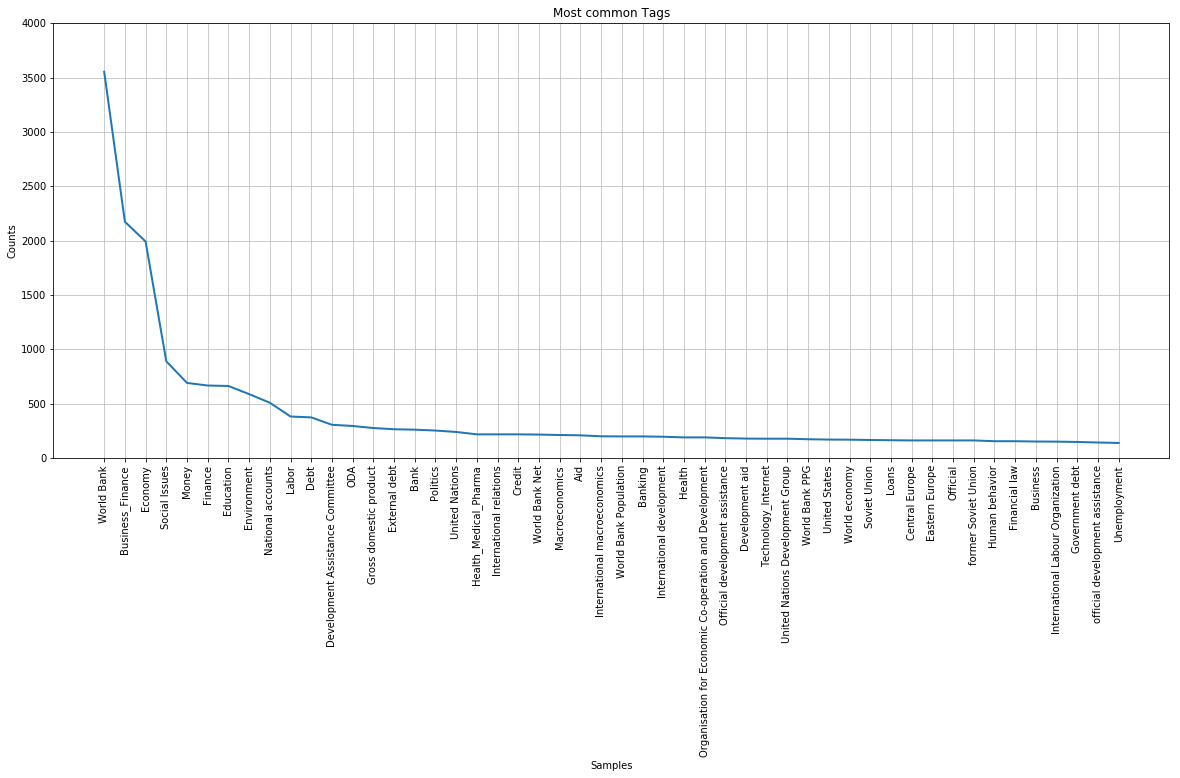

In [44]:
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 4000)
fdist_total_tags.plot(50, title = 'Most common Tags')

### Which tags should be ignored?

Only tags appearing less than 1000 times?

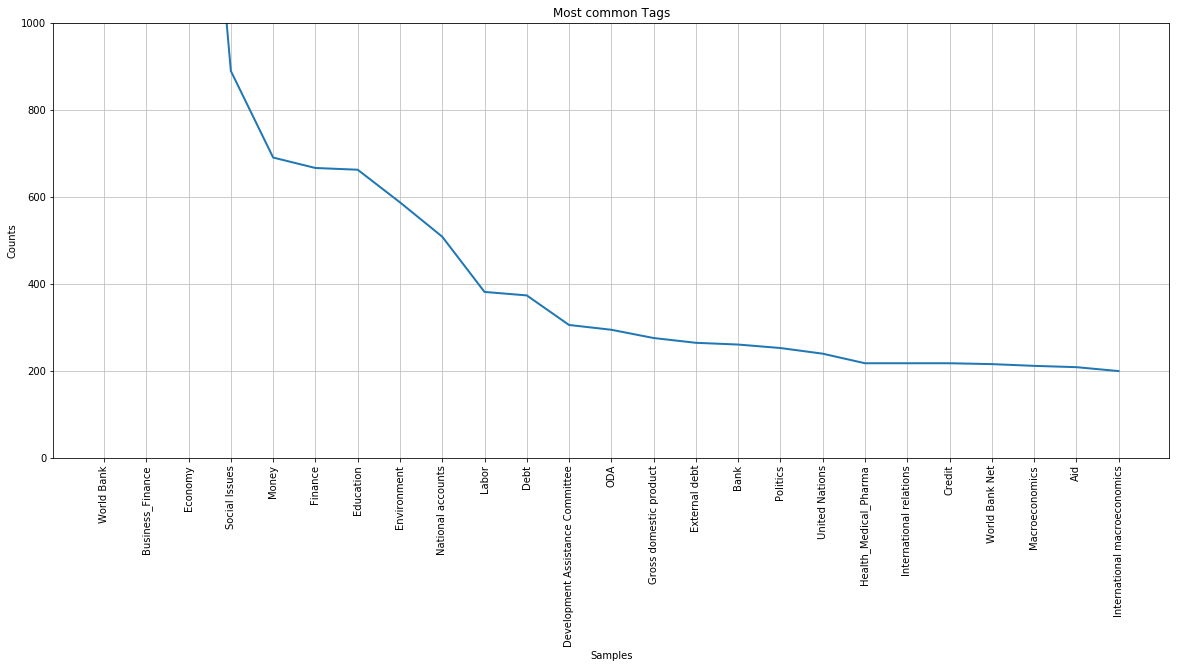

In [45]:
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 1000)
fdist_total_tags.plot(25, title = 'Most common Tags')

* excluding first 3 tags
* assumption: take the first 200 most common tags

In [46]:
list_chosen_tags = list_tags_sorted[3:203]
list_chosen_tags[:10]

[('Social Issues', 890),
 ('Money', 691),
 ('Finance', 667),
 ('Education', 663),
 ('Environment', 588),
 ('National accounts', 509),
 ('Labor', 382),
 ('Debt', 374),
 ('Development Assistance Committee', 306),
 ('ODA', 295)]

In [47]:
ll_name_desc_tags[0:10]

[['Domestic general government health expenditure per capita (current US$), countries',
  'Public expenditure on health from domestic sources per capita expressed in current US dollars.',
  ['Social Issues',
   'Politics',
   'Business_Finance',
   'Environment',
   'Economy',
   'National accounts',
   'Health systems by country',
   'Military budget',
   'World Bank Domestic',
   'World Bank']],
 ['Domestic general government health expenditure per capita (current US$), world regions',
  'Public expenditure on health from domestic sources per capita expressed in current US dollars.',
  ['Social Issues',
   'Environment',
   'Business_Finance',
   'Politics',
   'Economy',
   'National accounts',
   'Health systems by country',
   'Military budget',
   'World Bank Domestic',
   'World Bank']],
 ['Domestic general government health expenditure per capita (current US$), world',
  'Public expenditure on health from domestic sources per capita expressed in current US dollars.',
  ['Social

In [48]:
# CHANGE HARDCODE TO FLEXIBLE FUNCTION!
# def xxx(list_tags, pos1, pos2, ll_name_desc_tags): return ll_name_desc_tags_cleaned
# ------------------------------------------------------


# remove_list = [...]
for i, elements in enumerate(ll_name_desc_tags):
    if ('World Bank' in ll_name_desc_tags[i][2]) or ('Business_Finance' in ll_name_desc_tags[i][2]) or ('Economy' in ll_name_desc_tags[i][2]):
        # for elem in remove_list
        # --> multiple if's to ensure performane --> only if2 iff if1 is true, else continue and do not check
        # if elem in remove_list
        if ('World Bank' in ll_name_desc_tags[i][2]):
            ll_name_desc_tags[i][2].remove('World Bank')

In [49]:
ll_name_desc_tags[0:10]

[['Domestic general government health expenditure per capita (current US$), countries',
  'Public expenditure on health from domestic sources per capita expressed in current US dollars.',
  ['Social Issues',
   'Politics',
   'Business_Finance',
   'Environment',
   'Economy',
   'National accounts',
   'Health systems by country',
   'Military budget',
   'World Bank Domestic']],
 ['Domestic general government health expenditure per capita (current US$), world regions',
  'Public expenditure on health from domestic sources per capita expressed in current US dollars.',
  ['Social Issues',
   'Environment',
   'Business_Finance',
   'Politics',
   'Economy',
   'National accounts',
   'Health systems by country',
   'Military budget',
   'World Bank Domestic']],
 ['Domestic general government health expenditure per capita (current US$), world',
  'Public expenditure on health from domestic sources per capita expressed in current US dollars.',
  ['Social Issues',
   'Business_Finance',
 

### Removing fillerwords from name and describtion:

In [50]:
str_fillerwords = getTxt('..\\input\\fillerwords.txt')
list_fillerwords = str_fillerwords.split(',')
list_fillerwords[0:10]

['a',
 'an',
 'about',
 'above',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against']

#### Next steps
1. remove fillerwords from desc and name
2. export desc|name|tags
3. new notebook
4. import exportfile
5. classify docs
6. algo testing
7. (static, hardcode --> dynamic, functions)

In [51]:
if platform.system() == 'Windows':
    writeCsv(ll_name_desc_tags, '..\\output\\mldata.csv')
    writeCsv(list_tags_sorted, '..\\output\\tags.csv')
else:
    writeCsv(ll_name_desc_tags, '../output/mldata.csv')
    writeCsv(list_tags_sorted, '../output/tags.csv')